# Computing metadata for pavement cells

Given a 2D image of pavement cells, we can filter it by cell area or convexity and compute a persistence diagram to topologically describe the pattern. 

Relevant literature:

- M. Feng and M. Porter (2021) **Persistent Homology of Geospatial Data: A Case Study with Voting**. [DOI: 10.1137/19M1241519](https://doi.org/10.1137/19M1241519)
- FK. Clark, G. Weissbart, X. Wang, K. Harline, C-B. Li, P. Formosa-Jordan, AHK Roeder (2024) **A common pathway controls cell size in the sepal and leaf epidermis leading to a non-random pattern of giant cells.** [DOI: 10.1101/2024.07.26.605215](https://doi.org/10.1101/2024.07.26.605215)

## Extending images

One of the goals is to filter the images via adjacency complexes. These complexes, by construction, fail to detect holes when these are at the edge of the image/map. This could be an issue if a large-valued cell happens to touch the image's edge. The image thus will be extended (mirrored along its edges). Naturally, cells at the edge will now double in size or even quadruple for those at the corner! New will show up. These issues can distort our downstream analyses.

To prevent distortions, we'll keep track of two sets of values:
- The true values derived from the original image.
- The new values derived from the extended image.

We will also keep track of which cells are completely false (mirrored, not just extended).

In the end, we will only keep the true values for the original cells, and the mirrored cells will share the exact same values as their real counterparts.

## The script

- Load necessary packages. 

Just the basics are necessary. `json`, `os` and `glob` come by default. `Numpy`, `scipy`, `matplotlib`, and `pandas` are pretty standard.

I like `tifffile` to load TIFF images, but other options may be available. 


In [1]:
import glob
import os
import itertools
import json
import tifffile as tf
import numpy as np
import pandas as pd
from scipy import ndimage, stats, spatial

import matplotlib.pyplot as plt

## Load the data from a source directory `src`

- All the data files are insidea a `data` directory
- Each tissue/variant is its own folder
- We do `glob.glob` to get automatically the name of all the folders
- For example, the 3rd source folder `sidx = 3` corresponds to `../results/sepal/`

### Define a destination directory `dst`

- For consistency, the `results` folder should have the same structure as the `data` one.
- If the folder, say `../results/sepal/` is not existent, we can make it automatically

In [2]:
filesrcs = sorted(glob.glob(os.pardir + os.sep + 'data' + os.sep + '*' + os.sep))
filesrcs

['../data/leaf_25d_WT2/',
 '../data/leaf_25d_WT4/',
 '../data/leaf_25d_WT4_random/',
 '../data/sepal/',
 '../data/sepal_random/']

In [3]:
sidx = 0

src = filesrcs[sidx]
dst = os.pardir + os.sep + 'results' + os.sep + os.path.dirname(src).split(os.sep)[-1] + os.sep
print(dst)
if not os.path.isdir(dst):
    os.makedirs(dst)

../results/leaf_25d_WT2/


## Load the data

- Make a list of all the `.tiff` and `.tif` files inside the source folder.
- This is convenient for the random folders that contain several images

In [4]:
tifffiles = sorted(glob.glob(src + '*.tif*'))
print(tifffiles)

tidx = 0
tifffile = tifffiles[tidx]
_,filename = os.path.split(tifffile)
bname, _ = os.path.splitext(filename)
print(tidx, filename, bname, sep='\t')

['../data/leaf_25d_WT2/segmentation.tiff']
0	segmentation.tiff	segmentation


- Load a single image
- Create two padded copies by extending each axis 25%:
    - The `black` copy is padded with zeroes
    - The `frame` copy mirrors the axis values
- Get bounding boxes for every cell with `ndimage.find_objects` for both the original and extended images.

In [5]:
img = tf.imread(tifffile)
structure = ndimage.generate_binary_structure(img.ndim, 1)
css = ndimage.find_objects(img)
pady,padx = np.round(0.5*np.asarray(img.shape)).astype(int)

black = np.pad(img, [(pady,),(padx,)], mode='constant')
frame = np.pad(img, [(pady,),(padx,)], mode='symmetric')

ess = ndimage.find_objects(frame)
print(filename, img.min(), img.max(), img.shape, img.dtype, sep='\t')
print(filename, frame.min(), frame.max(), frame.shape, frame.dtype, sep='\t')

segmentation.tiff	1	547	(2844, 2976)	uint16
segmentation.tiff	1	547	(5688, 5952)	uint16


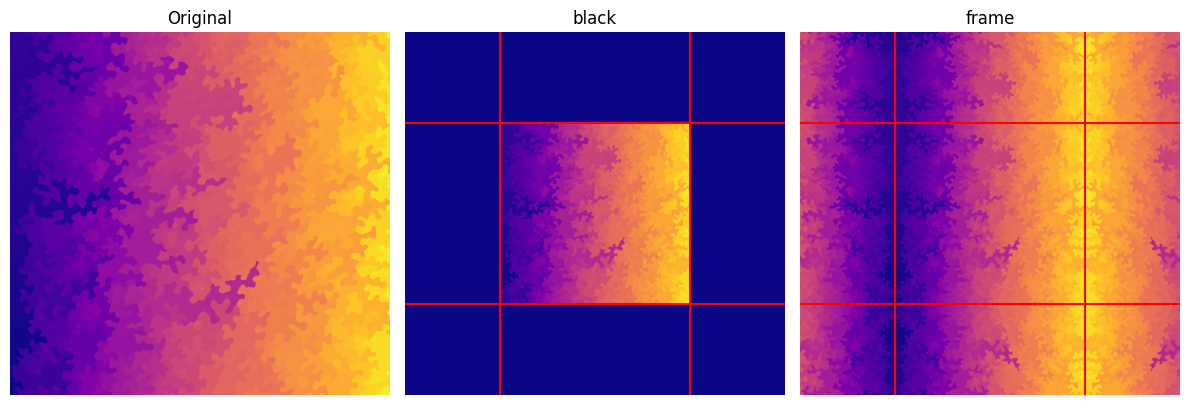

In [6]:
fig, ax = plt.subplots(1,3, figsize=(12,4)); i = 0
ax[i].imshow(img, cmap='plasma', origin='lower'); ax[i].set_title('Original'); i+=1
ax[i].imshow(black, cmap='plasma', origin='lower'); ax[i].set_title('black');  i+=1
ax[i].imshow(frame, cmap='plasma', origin='lower'); ax[i].set_title('frame');  i+=1
for i in [1,2]:
    ax[i].axvline(padx, c='r')
    ax[i].axvline(frame.shape[1] - padx, c='r')
    ax[i].axhline(pady, c='r')
    ax[i].axhline(frame.shape[0] - pady, c='r')
for a in ax.ravel():
    a.axis('off');
plt.tight_layout();

- For each of the cells, check if it now consists of one or more connected components.
- If so, label each of these new components as different cells.
- In a dictionary `extd`, keep track that these components are really a mirror of this or that cell.

In [7]:
extended = np.copy(frame)
uq = np.unique(frame) # List of labeled cells
minlabel = uq[-1] + 1 # The largest label in the original image
extd = dict() # Dictionary to keep track of mirrored cells

# Loop through all the cells
for label in uq[uq > 0]:
    extd[label] = []
    
    # Check if a cell is now multiple connected components in the `frame` image
    comp = frame[ess[label - 1]] == label
    labels,num = ndimage.label(comp, structure=structure)
    rss = ndimage.find_objects(labels)
    labels = labels.astype(extended.dtype)

    # For each of the new connected components
    for i,s_ in enumerate(rss):
        # If the component is part of the original cell, do nothing
        if np.any(black[ess[label-1]][s_]):
            pass
        # otherwise, mark the connected component with a new label
        else:
            extended[ess[label-1]][s_][ labels[s_] == i+1 ] = minlabel
            extd[label].append(minlabel)
            minlabel += 1

(slice(64, 214, None), slice(0, 52, None))	(slice(508, 936, None), slice(701, 805, None))


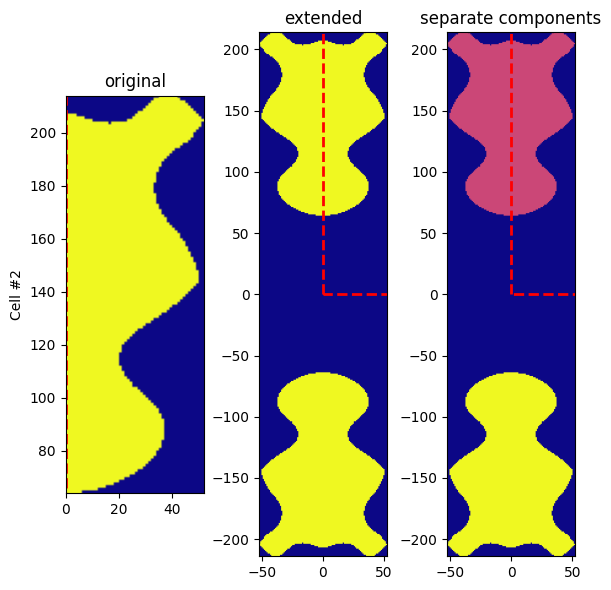

In [8]:
label = 2
comp = frame[ess[label-1]] == label
labels,num = ndimage.label(comp, structure=structure)

fig, ax = plt.subplots(1,3, figsize=(6,6)); i = 0
print(css[label-1], ess[label-1], sep='\t')
extent = (css[label-1][1].start, css[label-1][1].stop, css[label-1][0].stop, css[label-1][0].start)
ax[i].imshow(img[css[label-1]] == label, cmap='plasma', extent=extent); 
ax[i].set_ylabel('Cell #{}'.format(label))
ax[i].set_xlim(*extent[:2]); ax[i].set_ylim(extent[3], extent[2])

# extended
i += 1
extent = (ess[label-1][1].start-padx, ess[label-1][1].stop-padx, ess[label-1][0].stop-pady, ess[label-1][0].start-pady)
ax[i].imshow(comp, cmap='plasma', extent=extent, origin='lower'); i+=1
ax[i].imshow(labels, cmap='plasma', extent=extent, origin='lower')
for i in [1,2]:
    ax[i].set_xlim(*extent[:2]); ax[i].set_ylim(extent[3], extent[2])
title = ['original', 'extended', 'separate components']
for i in range(len(ax)):
    ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=2,c='r',zorder=1)
    ax[i].set_title(title[i])
plt.tight_layout();

(slice(2486, 2886, None), slice(0, 394, None))	(slice(3208, 4008, None), slice(359, 1147, None))


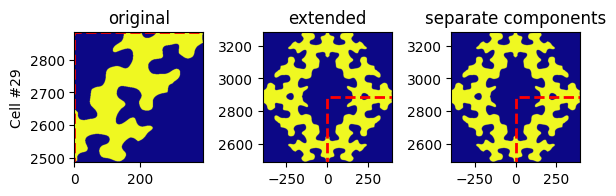

In [9]:
label = 29
comp = frame[ess[label-1]] == label
labels,num = ndimage.label(comp, structure=structure)

fig, ax = plt.subplots(1,3, figsize=(6,6)); i = 0
print(css[label-1], ess[label-1], sep='\t')
extent = (css[label-1][1].start, css[label-1][1].stop, css[label-1][0].stop, css[label-1][0].start)
ax[i].imshow(img[css[label-1]] == label, cmap='plasma', extent=extent); 
ax[i].set_ylabel('Cell #{}'.format(label))
ax[i].set_xlim(*extent[:2]); ax[i].set_ylim(extent[3], extent[2])

# extended
i += 1
extent = (ess[label-1][1].start-padx, ess[label-1][1].stop-padx, ess[label-1][0].stop-pady, ess[label-1][0].start-pady)
ax[i].imshow(comp, cmap='plasma', extent=extent, origin='lower'); i+=1
ax[i].imshow(labels, cmap='plasma', extent=extent, origin='lower')
for i in [1,2]:
    ax[i].set_xlim(*extent[:2]); ax[i].set_ylim(extent[3], extent[2])
title = ['original', 'extended', 'separate components']
for i in range(len(ax)):
    ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=2,c='r',zorder=1)
    ax[i].set_title(title[i])
plt.tight_layout();

(slice(153, 235, None), slice(33, 150, None))	(slice(487, 957, None), slice(603, 903, None))


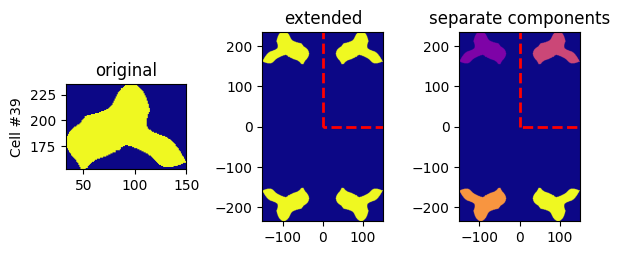

In [10]:
label = 39
comp = frame[ess[label-1]] == label
labels,num = ndimage.label(comp, structure=structure)

fig, ax = plt.subplots(1,3, figsize=(6,6)); i = 0
print(css[label-1], ess[label-1], sep='\t')
extent = (css[label-1][1].start, css[label-1][1].stop, css[label-1][0].stop, css[label-1][0].start)
ax[i].imshow(img[css[label-1]] == label, cmap='plasma', extent=extent); 
ax[i].set_ylabel('Cell #{}'.format(label))
ax[i].set_xlim(*extent[:2]); ax[i].set_ylim(extent[3], extent[2])

# extended
i += 1
extent = (ess[label-1][1].start-padx, ess[label-1][1].stop-padx, ess[label-1][0].stop-pady, ess[label-1][0].start-pady)
ax[i].imshow(comp, cmap='plasma', extent=extent, origin='lower'); i+=1
ax[i].imshow(labels, cmap='plasma', extent=extent, origin='lower')
for i in [1,2]:
    ax[i].set_xlim(*extent[:2]); ax[i].set_ylim(extent[3], extent[2])
title = ['original', 'extended', 'separate components']
for i in range(len(ax)):
    ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=2,c='r',zorder=1)
    ax[i].set_title(title[i])
plt.tight_layout();

### Extended image

- The final extended image distinguishes whether a cell has extended or if has been mirrored into separate connected components.
- In the former case, the label is kept
- In the latter, a new label is made

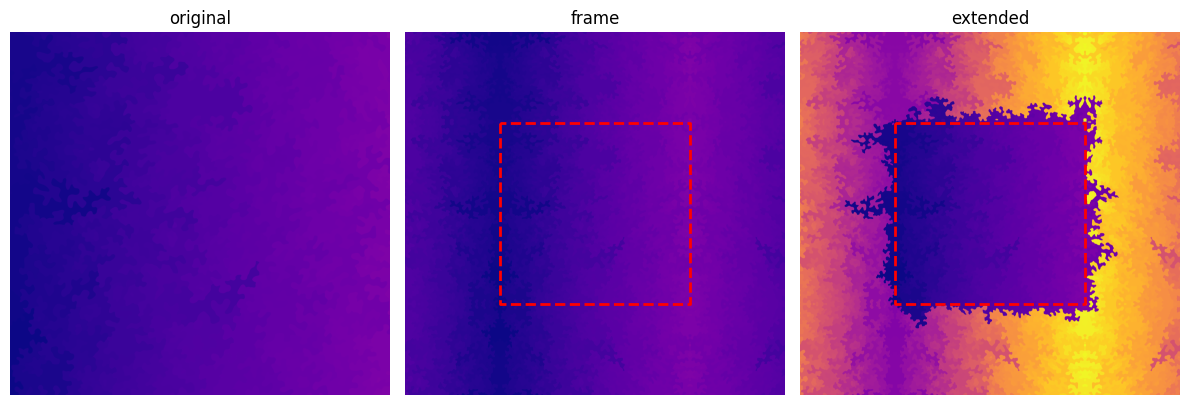

In [9]:
vmax = extended.max()
fig, ax = plt.subplots(1,3, figsize=(12,4)); i = 0
ax[i].imshow(img, cmap='plasma', origin='lower', vmin=0, vmax=vmax); i+=1

extent = (-padx, img.shape[1]+padx, img.shape[0]+pady, -pady)
ax[i].imshow(frame, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=vmax); i+=1
ax[i].imshow(extended, cmap='plasma', origin='lower', extent=extent, vmin=0, vmax=vmax); i+=1
for i in [1,2]:
    ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=2,c='r',zorder=1)
title = ['original', 'frame', 'extended']
for i in range(len(ax)):
    ax[i].axis('off');
    ax[i].set_title(title[i])
plt.tight_layout();

### Figure out bounding boxes for the cells in the extended image

- Compute centers of mass:
   - Just looking at the original image data `coms`
   - Looking at the extended image data `rcoms`

In [8]:
rss = ndimage.find_objects(extended)
coms = np.asarray(ndimage.center_of_mass(img, img, range(img.min(), img.max()+1)))
rcoms= np.asarray(ndimage.center_of_mass(extended, extended, range(extended.min(), extended.max()+1)))

In [9]:
# Auxiliary variables so they are not computed over and over again

pad = 2
xy1 = np.array([0.5,-0.5]).reshape(-1,1)
xy2 = np.array([-0.5,0.5]).reshape(-1,1)
bordermask = ndimage.generate_binary_structure(2,1).astype(int)
bordermask[1,1] = -bordermask.sum() + 1

### Compute metadata for each cell

- For each cell, find its border
- Compute its perimeter and area
- Get the convex hull and compare it to the original perimeter and area to compute convexity ratios

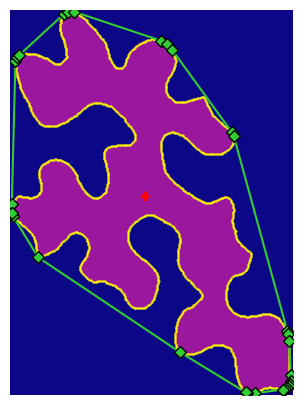

In [12]:
# Cell index/label/color
idx = 314

# Bounding box: add some padding on the sides for better visualization
s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
      np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
extent = (s_[1].start, s_[1].stop, s_[0].stop, s_[0].start)

# Make a new binary image: only highlight the chosen cell and make zero elsewhere
cell = img[s_] == idx + 1

# Compute the border of the cell
nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0)

# Compute the perimeter
label, n = ndimage.label(nzborder < 0, ndimage.generate_binary_structure(2,1))
hist, _ = np.histogram(label, range(1, n+2))
perimeter = np.sum(hist - 1) + n*np.sqrt(2)

# Get the pixel coordinates of the border
border = np.asarray(np.nonzero(nzborder < 0)).astype(float)

# Pad the border so that the resulting convex hull will have an strictly larger area than the input
chborder = np.hstack((border + 0.5, border - 0.5, border + xy1, border + xy2))

# Compute the convex hull of the cell
convexhull = spatial.ConvexHull(np.flip(chborder).T)
hull = convexhull.points[convexhull.vertices]
hull = np.vstack( (hull, hull[0])).T

# Visualize the results
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(cell, cmap='plasma', origin='upper', vmin=0, vmax=3)
ax.scatter(coms[idx,1] - extent[0], coms[idx, 0] - extent[3], c='r', marker='P', s=30)
ax.scatter(border[1], border[0] , c='yellow', marker='.', s=1)
ax.plot(hull[0], hull[1] , c='limegreen', marker='D', mec='k')
ax.axis('off');

## Make it a loop

- Put the above code inside a loop to compute values for all the cells
- Store the results in a DataFrame
- This DataFrame is then saved as a CSV file `_metadata.csv` in the same directory where the TIFFs are located.
- The loop only runs once: after that, it will simply load the pre-computed CSV to save time

In [10]:
columns = ['centerX', 'centerY', 'perimeter', 'area', 'ch_perimeter', 'ch_area', 'pconvexity', 'aconvexity']
datafile = src + bname + '_metadata.csv'
print(datafile)

if not os.path.isfile(datafile):
    pad = 2
    xy1 = np.array([0.5,-0.5]).reshape(-1,1)
    xy2 = np.array([-0.5,0.5]).reshape(-1,1)
    
    
    data = pd.DataFrame(0., index=range(1, len(css)+1), columns=columns)
    
    for idx in range(len(data)):
        
        s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
              np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
        cell = img[s_] == idx + 1
        area = cell.sum()
        
        nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0) < 0
        
        label, n = ndimage.label(nzborder, ndimage.generate_binary_structure(2,1))
        hist, _ = np.histogram(label, range(1, n+2))
        perimeter = np.sum(hist - 1) + n*np.sqrt(2)
    
        border = np.asarray(np.nonzero(nzborder)).astype(float)
        chborder = np.hstack((border + 0.5, border - 0.5, border + xy1, border + xy2))
        convexhull = spatial.ConvexHull(np.flip(chborder).T)
        
        data.loc[idx + 1] = [coms[idx,1], coms[idx,0], perimeter, area, 
                             convexhull.area, convexhull.volume, convexhull.area/perimeter, area/convexhull.volume] 
    data = data.astype({'area':int})
    data.to_csv(datafile, index=True, index_label='Label')

data = pd.read_csv(datafile).set_index('Label')
print(data.shape)
data.head()

../data/leaf_25d_WT2/segmentation_metadata.csv
(547, 8)


,centerX,centerY,perimeter,area,ch_perimeter,ch_area,pconvexity,aconvexity
Label,,,,,,,,
1,38.982724,7.927846,183.840620,984,171.707897,1408.0,0.934004,0.698864
2,38.788442,74.931299,530.717821,7700,405.851804,10657.5,0.764722,0.722496
3,4.419087,76.095436,65.213203,241,67.754109,254.0,1.038963,0.948819
4,36.087555,278.390461,764.587878,10462,574.828309,16280.5,0.751815,0.642609
5,54.063793,383.235363,418.534055,6866,375.432179,9260.5,0.897017,0.741429


### Determine which cells have been extended and which are mirrored

- Make an extended DataFrame with information from the extended image
- Check whether the extended cell is fully contained in the black margin of the `black` image
    - If so, the cell is completely mirrored and tagged as False
    - Else, the cell is simply extended and kept as True
- Have the center of mass for each extended and mirrored cell
- Copy the information from the original image and cells
- If the cell is mirrored, its information will match its real counterpart

In [11]:
datafile = src + bname + '_extended_metadata.csv'
print(datafile)

if not os.path.isfile(datafile):

    # Empty dataframe
    extdata = pd.DataFrame(index=range(1 , 1+len(rss)), columns = ['true_cell', 'extcenterX', 'extcenterY'] + columns)
    
    # Check whether the cell is real or not
    for idx in range(len(rss)):
        extdata.iloc[idx, 0] = np.any(black[rss[idx]][extended[rss[idx]] == idx + 1])
    print(len(extdata[extdata['true_cell']]) == len(data))
    
    # Keep track of their center of mass 
    # Remember to translate the coordinates so they match the original image axes
    extdata['extcenterX'] = rcoms[:,1] - padx
    extdata['extcenterY'] = rcoms[:,0] - pady
    
    # Copy the rest of the information from the original dataset
    extdata['centerX'] = extdata['extcenterX']
    extdata['centerY'] = extdata['extcenterY']
    extdata.loc[data.index, columns] = data.loc[:, columns]
    
    # Match real and mirrored counterparts
    for cell in extd:
        if len(extd[cell]) > 0:
            for label in extd[cell]:
                extdata.loc[label, columns[2:]] = data.loc[cell, columns[2:]]

    extdata.to_csv(datafile, index=True, index_label='Label')

extdata = pd.read_csv(datafile).set_index('Label')
print(extdata.shape)
extdata.head()

../data/leaf_25d_WT2/segmentation_extended_metadata.csv
True
(2084, 11)


,true_cell,extcenterX,extcenterY,centerX,centerY,perimeter,area,ch_perimeter,ch_area,pconvexity,aconvexity
Label,,,,,,,,,,,
1,True,-0.5,-0.500000,38.982724,7.927846,183.840620,984.0,171.707897,1408.0,0.934004,0.698864
2,True,-0.5,74.931299,38.788442,74.931299,530.717821,7700.0,405.851804,10657.5,0.764722,0.722496
3,True,-0.5,76.095436,4.419087,76.095436,65.213203,241.0,67.754109,254.0,1.038963,0.948819
4,True,-0.5,278.390461,36.087555,278.390461,764.587878,10462.0,574.828309,16280.5,0.751815,0.642609
5,True,-0.5,383.235363,54.063793,383.235363,418.534055,6866.0,375.432179,9260.5,0.897017,0.741429


## Get neighbors

- Make a JSON file listing all the neighbors for every cell `_neighbors.json`
- The keys are all the cell labels
- For each key, a list with neighbor labels is given
- Two cells are neighbors if they touch in at least one pixel
- The resulting JSON is stored in the same directory as the rest of TIFFs

In [12]:
datafile = src + bname + '_extended_neighbors.json'
print(datafile)

if not os.path.isfile(datafile):
    neighbors = dict()
    
    # pad so that all neighboring cells are considered
    # make sure the pad does not go beyond image limits
    pad = 2
    for idx in range(len(rss)):
        s_ = (np.s_[max(0, rss[idx][0].start - pad) : min(extended.shape[0], rss[idx][0].stop + pad)] , 
              np.s_[max(0, rss[idx][1].start - pad) : min(extended.shape[1], rss[idx][1].stop + pad)])
        cell = extended[s_] == idx + 1

        # get the external border of the cell
        nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0) > 0

        # the list of neighbors for this cell is the list of unique labels on its external border
        neighbors[idx + 1] = np.unique(extended[s_][nzborder]).tolist()
    
    with open(datafile, 'w') as f:
        json.dump(neighbors, f, indent=1, separators=(',', ':'))

# JSON by construction does not recognize numerical keys; only string keys
def json_keys_to_int(json_dict):
    return {int(k): v for k, v in json_dict.items()}
    
with open(datafile, "r") as f:
    neighbors = json.load(f, object_hook=json_keys_to_int)
print(len(neighbors))
print(neighbors[1])

../data/leaf_25d_WT2/segmentation_extended_neighbors.json
2084
[2, 48, 548, 618]


----

# Next Notebooks

- New notebooks should focus on computing persistence diagrams using various filtrations

---

# IGNORE

In [18]:
datafile = src + bname + '_extended_metadata.csv'
print(datafile)

if not os.path.isfile(datafile):
    cs = ['SWcorner','SEcorner','NEcorner','NWcorner','extcenter']
    extcolumns = list(itertools.chain(*[ [f'{c}X', f'{c}Y'] for c in cs ])) + columns
    extdata = pd.DataFrame(0., index=range(1, len(rss)+1), columns=extcolumns)
    
    for idx in range(len(extdata)):
        
        extdata.loc[idx + 1, extcolumns[:2*len(cs)]] = [
            rss[idx][1].start, rss[idx][0].start, # southwest
            rss[idx][1].stop, rss[idx][0].start, # southeast
            rss[idx][1].stop, rss[idx][0].stop, # northeast
            rss[idx][1].start, rss[idx][0].stop, #northwest
            rcoms[idx,1], rcoms[idx,0]
        ] 
    extdata = extdata.astype(dict(zip(extcolumns[:2*len(cs)-2],[int for _ in range(2*len(cs)-2)])))

    # Translate the coordinates so they match with those from the original image
    extdata.loc[:,[c+'X' for c in cs]] -= padx
    extdata.loc[:,[c+'Y' for c in cs]] -= pady

    # Check if the SW, SE, NE, NW bounding box coordinates are in the original image
    swx = (extdata['SWcornerX'] >= 0) & (extdata['SWcornerX'] <= img.shape[1])
    swy = (extdata['SWcornerY'] >= 0) & (extdata['SWcornerY'] <= img.shape[0])
    
    sex = (extdata['SEcornerX'] >= 0) & (extdata['SEcornerX'] <= img.shape[1])
    sey = (extdata['SEcornerY'] >= 0) & (extdata['SEcornerY'] <= img.shape[0])
    
    nex = (extdata['NEcornerX'] >= 0) & (extdata['NEcornerX'] <= img.shape[1])
    ney = (extdata['NEcornerY'] >= 0) & (extdata['NEcornerY'] <= img.shape[0])
    
    nwx = (extdata['NWcornerX'] >= 0) & (extdata['NWcornerX'] <= img.shape[1])
    nwy = (extdata['NWcornerY'] >= 0) & (extdata['NWcornerY'] <= img.shape[0])

    # If at least one corner is in the original image, the cell is deemed as "true"
    extdata['true_cell'] = ((swx & swy) | (sex & sey) | (nex & ney) | (nwx & nwy))
    
    extdata['centerX'] = extdata['extcenterX']
    extdata['centerY'] = extdata['extcenterY']
    extdata.loc[data.index, columns] = data.loc[:, columns]
    for cell in extd:
        if len(extd[cell]) > 0:
            for label in extd[cell]:
                extdata.loc[label, columns[2:]] = data.loc[cell, columns[2:]]
    extdata.to_csv(datafile, index=True, index_label='Label')

extdata = pd.read_csv(datafile).set_index('Label')
print(extdata.shape)
extdata

../data/leaf_25d_WT4/segmentation_extended_metadata.csv
(1412, 11)


,true_cell,extcenterX,extcenterY,centerX,centerY,perimeter,area,ch_perimeter,ch_area,pconvexity,aconvexity
Label,,,,,,,,,,,
1,True,-0.5,-0.500000,61.373869,58.106198,580.546248,11940.0,470.552743,15041.0,0.810534,0.793830
2,True,-0.5,142.452079,18.980871,142.452079,408.048773,5123.0,366.442229,6587.5,0.898035,0.777685
3,True,-0.5,-0.500000,232.277407,211.739969,2325.228714,50817.0,1257.422040,104085.0,0.540773,0.488226
4,True,-0.5,290.688065,26.463696,290.688065,260.894444,3209.0,236.955745,3862.5,0.908244,0.830809
5,True,-0.5,411.948938,250.284159,411.948938,2834.414572,64960.0,1388.076410,122924.5,0.489722,0.528454
...,...,...,...,...,...,...,...,...,...,...,...
1408,False,3012.5,3035.034398,3012.500000,3035.034398,156.740115,814.0,163.992532,1000.0,1.046270,0.814000
1409,False,3012.5,3368.593664,3012.500000,3368.593664,119.355339,726.0,120.215638,771.5,1.007208,0.941024
1410,False,3012.5,2952.934928,3012.500000,2952.934928,177.225397,1045.0,173.381538,1200.0,0.978311,0.870833
